# Training DQNN with Qiskit

## Introduction
This tutorial is based on the paper [Training deep quantum neural networks](https://www.nature.com/articles/s41467-020-14454-2). We implement the DQNN model proposed in the paper with `qiskit` library.

## Used libraries

In [26]:
import numpy as np
from typing import Union, List, Callable
from collections import deque

from qiskit.quantum_info import random_unitary, random_density_matrix, random_statevector
from qiskit.quantum_info import DensityMatrix, Statevector, partial_trace, state_fidelity
from qiskit.quantum_info.states.quantum_state import Operator
from qiskit.extensions import HamiltonianGate

from qiskit.algorithms.optimizers import SPSA, ADAM

from tqdm import trange
from torch.utils.tensorboard import SummaryWriter

## Opflow-DQNN model class

This is the model that utilzes `qiskit.quantum_info` module for calculations, which is essential same as [this implimentation](https://github.com/qigitphannover/DeepQuantumNeuralNetworks/blob/master/DQNN_basic.ipynb). Unitraries update rule (backprob) in the [paper](https://www.nature.com/articles/s41467-020-14454-2) has been integrated.

In [27]:
class OpflowDQNN(object):

    def __init__(self, qnnArch:List[int], epsilon:float=0.1, lamda:float=1):
        """ Deep Quantum Neural Network 
        Args:
            qnnArch: list of integers representing the architecture of the DQNN. e.g. [2, 3, 2] represents 2q input, 3q hidden, 2q output
        """
        self.qnnArch = qnnArch
        self.epsilon = epsilon
        self.lamda = lamda

    def makeRandomUnitaries(self, seed:int=None):
        """ Randomly initialize the unitaries of the DQNN
        Args:
            seed: random seed
        """
        unitaries = []
        for l in range(len(self.qnnArch)-1):
            unitaries.append(
                np.empty(
                    shape=(self.qnnArch[l+1], 2**(self.qnnArch[l]+1), 2**(self.qnnArch[l]+1)), 
                    dtype=np.complex128
                )
            )
            for j in range(self.qnnArch[l+1]):
                unitaries[l][j, : :] = random_unitary(2**(self.qnnArch[l]+1), seed=(seed+j) if seed is not None else None).data
        return unitaries

    def applyLayerChannel(self, unitaries:List[np.ndarray], l:int, inputState:DensityMatrix):
        numInputQubits = self.qnnArch[l]
        numOutputQubits = self.qnnArch[l+1]
        inputWires = list(range(numInputQubits))
        outputWires = list(range(numInputQubits, numInputQubits+numOutputQubits))
        layerUnitaries = unitaries[l]
        # inputState = DensityMatrix(inputState)
        inputState = inputState.expand(DensityMatrix.from_int(0, dims=2**numOutputQubits))
        # apply layer unitaries
        for j in range(numOutputQubits):
            # assert Operator(layerUnitaries[j, :, :]).is_unitary(), f"`unitaries[{l}][{j}, :, :]` is not unitary"
            inputState = inputState.evolve(Operator(layerUnitaries[j, : , :]), qargs=inputWires+[outputWires[j]])
        return partial_trace(inputState, qargs = inputWires)

    def applyAdjointLayerChannel(self, unitaries:List[np.ndarray], l:int, outputState:DensityMatrix):
        numInputQubits = self.qnnArch[l]
        numOutputQubits = self.qnnArch[l+1]
        inputWires = list(range(numInputQubits))
        outputWires = list(range(numInputQubits, numInputQubits+numOutputQubits))
        layerUnitaries = unitaries[l]
        # outputState = DensityMatrix(outputState)
        outputState = DensityMatrix(np.eye(2**numInputQubits)).expand(outputState)
        projOp = Operator(np.eye(2**numInputQubits)).expand(DensityMatrix.from_int(0, dims=2**numOutputQubits).to_operator())
        # apply adjoing layer unitaries
        for j in range(numOutputQubits-1, -1, -1):
            # assert Operator(layerUnitaries[j, :, :]).is_unitary(), f"`unitaries[{l}][{j}, :, :]` is not unitary"
            outputState = outputState.evolve(Operator(layerUnitaries[j, :, :]).adjoint(), qargs=inputWires+[outputWires[j]])
        return partial_trace(DensityMatrix(projOp @ outputState.to_operator()), outputWires)

    def feedforward(self, unitaries:List[np.ndarray], inputs:List[Union[Statevector, DensityMatrix, np.ndarray]]):
        """ Forward pass of the DQNN
        Args:
            unitaries: list of unitary parameters per layer
            inputs: array of input states of shape (batch_size, input_dim, input_dim) or (batch_size, input_dim)

        Returns: 
            outputs: deque of "array of layer states of shape (batch_size, output_dim, output_dim)" per layer
        """
        forward_process = []
        for quantum_state in inputs:
            layer_output = deque()
            quantum_state = DensityMatrix(quantum_state)
            layer_output.append(quantum_state)
            for l in range(len(self.qnnArch)-1):
                quantum_state = self.applyLayerChannel(unitaries, l, quantum_state)
                layer_output.append(quantum_state)
            forward_process.append(layer_output)

        layer_outputs = []
        for l in range(len(self.qnnArch)):
            layer_outputs.append(np.stack([forward_process[x][l] for x in range(len(inputs))]))
        return layer_outputs

    def backpropagation(self, unitaries:List[np.ndarray], targets:List[Union[Statevector, DensityMatrix, np.ndarray]]):
        """ Backward pass of the DQNN
        Args:
            unitaries: list of unitary parameters per layer
            targets: array of target states of shape (batch_size, output_dim, output_dim) or (batch_size, output_dim)

        Returns: 
            outputs: deque of "array of layer states of shape (batch_size, input_dim, input_dim)" per layer
        """
        backward_process = []
        for povm_measurement in targets:
            layer_output = deque()
            povm_measurement = DensityMatrix(povm_measurement)
            layer_output.appendleft(povm_measurement)
            for l in range(len(self.qnnArch)-2, -1, -1):
                povm_measurement = self.applyAdjointLayerChannel(unitaries, l, povm_measurement)
                layer_output.appendleft(povm_measurement)
            backward_process.append(layer_output)

        layer_outputs = []
        for l in range(len(self.qnnArch)):
            layer_outputs.append(np.stack([backward_process[x][l] for x in range(len(targets))]))
        return layer_outputs

    def step(self, unitaries:List[np.ndarray], inputs:List[Union[Statevector, DensityMatrix, np.ndarray]], targets:List[Union[Statevector, DensityMatrix, np.ndarray]]):
        """ Perform a single step of the DQNN
        Args:
            unitaries: list of unitary parameters per layer. This will be updated in-place.
            inputs: array of input states of shape (batch_size, input_dim, input_dim) or (batch_size, input_dim)
            targets: array of target states of shape (batch_size, output_dim, output_dim) or (batch_size, output_dim)

        Returns: 
            outputstate: array of (previous) output states of shape (batch_size, output_dim, output_dim) or (batch_size, output_dim)
        Note:
            This update is only suitable for state fidelity cost function.
        """
        # feedforward & backpropagation
        feedforward_results = self.feedforward(unitaries, inputs)
        backpropagation_results = self.backpropagation(unitaries, targets)

        for l in range(len(self.qnnArch)-1):
            xTrMmatrices = []
            numInputQubits = self.qnnArch[l]
            numOutputQubits = self.qnnArch[l+1]
            inputWires = list(range(numInputQubits))
            outputWires = list(range(numInputQubits, numInputQubits+numOutputQubits))
            layerUnitaries = unitaries[l]
            layerInputStates = feedforward_results[l]
            layerOutputStates = backpropagation_results[l+1]
            # make update matrices
            for layerInputState, layerOutputState in zip(layerInputStates, layerOutputStates):
                Amatrices = deque()
                Bmatrices = deque()
                TrMmatrices = list()
                astate = DensityMatrix(layerInputState).expand(DensityMatrix.from_int(0, dims=2**numOutputQubits))
                bstate = DensityMatrix(np.eye(2**numInputQubits)).expand(DensityMatrix(layerOutputState))
                for j in range(numOutputQubits):
                    astate = astate.evolve(layerUnitaries[j, :, :], qargs=inputWires+[outputWires[j]])
                    Amatrices.append(astate.data)
                for j in range(numOutputQubits-1, -1, -1):
                    Bmatrices.appendleft(bstate.data)
                    if j != 0:
                        bstate = bstate.evolve(Operator(layerUnitaries[j, :, :]).adjoint(), qargs=inputWires+[outputWires[j]])
                for j in range(numOutputQubits):
                    # assert np.isclose(np.trace(Amatrices[j] @ Bmatrices[j]) , np.mean(measout[:, x])), "A or B matrix is incorrect"
                    TrMmatrices.append(partial_trace(self._commutator(Amatrices[j], Bmatrices[j]), qargs=outputWires[:j]+outputWires[j+1:]).data)
                    # assert TrMmatrices[j].shape == layerUnitaries[j].shape, f"TrM matrix is incorrect ({TrMmatrices[-1].shape} != {layerUnitaries.shape})"
                xTrMmatrices.append(TrMmatrices)
            xTrMmatrices = np.stack(xTrMmatrices)
            Kmatrices = 1j * (2**numInputQubits) / self.lamda * xTrMmatrices.mean(axis=0)
            # assert len(xTrMmatrices)==len(targets)
            # replace unitaries
            for j in range(numOutputQubits):
                # assert Operator(Kmatrices[j]) == Operator(Kmatrices[j]).adjoint()
                unitaries[l][j, :, :] = np.matmul(HamiltonianGate(Kmatrices[j], time=-self.epsilon).to_matrix(), unitaries[l][j, :, :])
                # assert Operator(unitaries[l][j, :, :]).is_unitary()
        return self.cost(feedforward_results[-1], targets)

    @staticmethod
    def cost(outputs:np.ndarray, targets:np.ndarray):
        """ Calculate the cost of the DQNN
        Args:
            outputs: array of output states of shape (batch_size, output_dim, output_dim) or (batch_size, output_dim)
            targets: array of target states of shape (batch_size, output_dim, output_dim) or (batch_size, output_dim)

        Returns: 
            cost: float
        """
        # assert len(outputs) == len(targets)
        cost = 0
        for output, target in zip(outputs, targets):
            cost += state_fidelity(DensityMatrix(output), DensityMatrix(target))
        return cost/len(targets)

    @staticmethod
    def _commutator(A, B):
        # assert A.shape == B.shape
        # assert len(A.shape) == 2
        return np.matmul(A, B) - np.matmul(B, A)


    def __call__(self, unitaries, inputs):
        return self.feedforward(unitaries, inputs)[-1]

## Circuit-DQNN model class

This is the model that utilzes `qiskit.circuits` module for forward process. Thus, the unitaries would be parameterized quantum circuits (PQC). Unitraries update rule (backprob) in the [paper](https://www.nature.com/articles/s41467-020-14454-2) cannot be used in this case. Instead, we use the gradient descent method to update the parameters.

In [42]:
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

param = RealAmplitudes(num_qubits=2, reps=3).parameters
RealAmplitudes(num_qubits=2, reps=3).num_parameters

qc = QuantumCircuit(5)
for i in range(2, 5):
    _qc = RealAmplitudes(num_qubits=3, reps=1)
    qc.compose(_qc.assign_parameters(ParameterVector(f'theta{i}', _qc.num_parameters)), [0, 1, i], inplace=True)
qc.num_parameters

18

In [39]:
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import COBYLA
from qiskit.providers.aer import AerSimulator

class CircuitDQNN(object):

    def __init__(
            self, qnnArch:List[int], 
            feature_map:QuantumCircuit, 
            target_map:QuantumCircuit,
            quantum_instance:QuantumInstance,
            unitary_class:Callable, *args, **kwargs
        ):
        """ Deep Quantum Neural Network 
        Args:
            qnnArch: list of integers representing the architecture of the DQNN. e.g. [2, 3, 2] represents 2q input, 3q hidden, 2q output
            feature_map: QuantumCircuit that maps input data to quantum states
            target_map: QuantumCircuit that maps target data to quantum states
            unitary_class: function that returns a parameterized quantum circuit of class `qiskit.circuit.QuantumCircuit`. First argument should be the number of qubits.
            *args, **kwargs: arguments to be passed to `unitary_class`
        """
        assert qnnArch[0] == feature_map.num_qubits, "feature map must have same number of qubits as input"
        assert qnnArch[-1] == target_map.num_qubits, "target map must have same number of qubits as output"
        self.qnnArch = qnnArch
        self.quantum_instance = quantum_instance
        self.unitary_class = unitary_class
        self.args = args
        self.kwargs = kwargs
        self.n_qubits = max(np.array(qnnArch)[:-1]+np.array(qnnArch)[1:])
        self.feature_map = feature_map.assign_parameters(ParameterVector('X', feature_map.num_parameters))
        self.target_map = target_map.assign_parameters(ParameterVector('M', target_map.num_parameters))
        self.num_parameters = 0
        self.parameters = []

        self.dqnn = QuantumCircuit(self.n_qubits, qnnArch[-1], name='DQNN')
        self.dqnn.compose(self.feature_map, self.qnnArch[0], inplace=True)
        for l in range(len(qnnArch)-1):
            numInputQubits = self.qnnArch[l]
            numOutputQubits = self.qnnArch[l+1]
            inputWires = list(range(numInputQubits))
            outputWires = list(range(numInputQubits, numInputQubits+numOutputQubits))
            for j in range(numOutputQubits):
                _qc = self.unitary_class(numInputQubits+1, *self.args, **self.kwargs)
                _qc = _qc.assign_parameters(ParameterVector(f'θ[{l},{j}]', _qc.num_parameters))
                self.num_parameters += _qc.num_parameters
                self.parameters += list(_qc.parameters)
                self.dqnn.compose(_qc, inputWires+outputWires[j:j+1], inplace=True)
            self.dqnn.reset(inputWires)
            for j in range(numOutputQubits):
                self.dqnn.swap(j, outputWires[j])
        self.dqnn.compose(self.target_map.inverse(), self.qnnArch[-1], inplace=True)

    def feedforward(self, parameters:np.ndarray, inputs:List[np.ndarray]):
        """ Forward pass of the DQNN
        Args:
            parameters: 1D array of parameters
            inputs: array of input data of shape (batch_size, self.feature_map.num_parameters)

        Returns: 
            outputs: deque of "array of layer states of shape (batch_size, output_dim, output_dim)" per layer
        """
        assert len(parameters) == self.num_parameters, "number of parameters must match number of parameters in DQNN"
        dqnn = self.dqnn.assign_parameters(dict(zip(self.parameters, parameters)))
        return_circuits = []
        for input in inputs:
            return_circuits.append(dqnn.assign_parameters(dict(zip(self.feature_map.parameters, input))))
        return return_circuits

    def cost(self, outputs:List[QuantumCircuit], targets:np.ndarray):
        """ Calculate the cost of the DQNN
        Args:
            outputs: list of circuits representing the output of the DQNN.
            targets: array of target data of shape (batch_size, self.target_map.num_parameters)

        Returns: 
            cost: float
        """
        # assert len(outputs) == len(targets)
        cost = 0
        return_circuits = []
        for return_circuit in outputs:
            return_circuits.append(return_circuit.assign_parameters(dict(zip(self.target_map.parameters, targets))))
            if not 'statevector' in self.quantum_instance.backend_name():
                return_circuits[-1].measure(list(range(self.qnnArch[-1])), list(range(self.qnnArch[-1])))
        results = self.quantum_instance.execute(return_circuits)
        if not 'statevector' in self.quantum_instance.backend_name():
            costs = results.get_counts() # TODO: 

    def step(self, unitaries:List[np.ndarray], inputs:List[Union[Statevector, DensityMatrix, np.ndarray]], targets:List[Union[Statevector, DensityMatrix, np.ndarray]]):
        """ Perform a single step of the DQNN
        Args:
            unitaries: list of unitary parameters per layer. This will be updated in-place.
            inputs: array of input states of shape (batch_size, input_dim, input_dim) or (batch_size, input_dim)
            targets: array of target states of shape (batch_size, output_dim, output_dim) or (batch_size, output_dim)

        Returns: 
            outputstate: array of (previous) output states of shape (batch_size, output_dim, output_dim) or (batch_size, output_dim)
        Note:
            This update is only suitable for state fidelity cost function.
        """
        # feedforward & backpropagation
        feedforward_results = self.feedforward(unitaries, inputs)
        backpropagation_results = self.backpropagation(unitaries, targets)

        for l in range(len(self.qnnArch)-1):
            xTrMmatrices = []
            numInputQubits = self.qnnArch[l]
            numOutputQubits = self.qnnArch[l+1]
            inputWires = list(range(numInputQubits))
            outputWires = list(range(numInputQubits, numInputQubits+numOutputQubits))
            layerUnitaries = unitaries[l]
            layerInputStates = feedforward_results[l]
            layerOutputStates = backpropagation_results[l+1]
            # make update matrices
            for layerInputState, layerOutputState in zip(layerInputStates, layerOutputStates):
                Amatrices = deque()
                Bmatrices = deque()
                TrMmatrices = list()
                astate = DensityMatrix(layerInputState).expand(DensityMatrix.from_int(0, dims=2**numOutputQubits))
                bstate = DensityMatrix(np.eye(2**numInputQubits)).expand(DensityMatrix(layerOutputState))
                for j in range(numOutputQubits):
                    astate = astate.evolve(layerUnitaries[j, :, :], qargs=inputWires+[outputWires[j]])
                    Amatrices.append(astate.data)
                for j in range(numOutputQubits-1, -1, -1):
                    Bmatrices.appendleft(bstate.data)
                    if j != 0:
                        bstate = bstate.evolve(Operator(layerUnitaries[j, :, :]).adjoint(), qargs=inputWires+[outputWires[j]])
                for j in range(numOutputQubits):
                    # assert np.isclose(np.trace(Amatrices[j] @ Bmatrices[j]) , np.mean(measout[:, x])), "A or B matrix is incorrect"
                    TrMmatrices.append(partial_trace(self._commutator(Amatrices[j], Bmatrices[j]), qargs=outputWires[:j]+outputWires[j+1:]).data)
                    # assert TrMmatrices[j].shape == layerUnitaries[j].shape, f"TrM matrix is incorrect ({TrMmatrices[-1].shape} != {layerUnitaries.shape})"
                xTrMmatrices.append(TrMmatrices)
            xTrMmatrices = np.stack(xTrMmatrices)
            Kmatrices = 1j * (2**numInputQubits) / self.lamda * xTrMmatrices.mean(axis=0)
            # assert len(xTrMmatrices)==len(targets)
            # replace unitaries
            for j in range(numOutputQubits):
                # assert Operator(Kmatrices[j]) == Operator(Kmatrices[j]).adjoint()
                unitaries[l][j, :, :] = np.matmul(HamiltonianGate(Kmatrices[j], time=-self.epsilon).to_matrix(), unitaries[l][j, :, :])
                # assert Operator(unitaries[l][j, :, :]).is_unitary()
        return self.cost(feedforward_results[-1], targets)

    @staticmethod
    def cost(outputs:np.ndarray, targets:np.ndarray):
        """ Calculate the cost of the DQNN
        Args:
            outputs: array of output states of shape (batch_size, output_dim, output_dim) or (batch_size, output_dim)
            targets: array of target states of shape (batch_size, output_dim, output_dim) or (batch_size, output_dim)

        Returns: 
            cost: float
        """
        # assert len(outputs) == len(targets)
        cost = 0
        for output, target in zip(outputs, targets):
            cost += state_fidelity(DensityMatrix(output), DensityMatrix(target))
        return cost/len(targets)

    def __call__(self, unitaries, inputs):
        return self.feedforward(unitaries, inputs)[-1]

In [41]:
from qiskit.circuit.library import TwoLocal
def Ufunc(n):
    return TwoLocal(n, 'ry', 'cz', reps=1, entanglement='linear')



dqnn = CircuitDQNN(qnnArch=[2, 3, 2], unitary_class=Ufunc)
dqnn.composeLayerQuantumCircuit(1)
dqnn.dqnn.draw()

»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
«     ┌────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                                                   ├»
«     │                                                                                                    │»
«q_1: ┤1                                                                                                   ├»
«     │  TwoLocal(theta10[0],theta10[1],theta10[2],theta10[3],theta10[4],theta10[5],theta10[6],theta10[7]) │»
«q_2: ┤2                                                                                                   ├»
«     │                                                                                                    │»
«q_3: ┤3                                                                                                   ├»
«     └────────────────────────────────────────────────────────────────────────────────────────────────────┘»
«q_4: ──────────────────────────────────────────────────────────────────────────────────────────────────────»
«                                                                                                           »
«     ┌────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                                                   ├»
«     │                                                                                                    │»
«q_1: ┤1                                                                                                   ├»
«     │                                                                                                    │»
«q_2: ┤2 TwoLocal(theta11[0],theta11[1],theta11[2],theta11[3],theta11[4],theta11[5],theta11[6],theta11[7]) ├»
«     │                                                                                                    │»
«q_3: ┤                                                                                                    ├»
«     │                                                                                                    │»
«q_4: ┤3                                                                                                   ├»
«     └────────────────────────────────────────────────────────────────────────────────────────────────────┘»
«                
«q_0: ─|0>──X────
«           │    
«q_1: ─|0>──┼──X─
«           │  │ 
«q_2: ─|0>──┼──┼─
«           │  │ 
«q_3: ──────X──┼─
«              │ 
«q_4: ─────────X─
«

## Data preparation & Cost functions

Training data $\vert \psi_{in} \rangle$ is sampled from Haar measure using `qiskit.quantum_info.random_statevector`. The type of training data is therefore `qiskit.quantum_info.Statevector`. The target data $\vert \psi_{out} \rangle$ is generated with arbitrary $V$, s.t. $\vert \psi_{out} \rangle=V\vert \psi_{in} \rangle$. However, to match with the DQNN forward output, the type of target data is `torch.tensor`. The cost function is defined as the average fidelity between the output state $\vert \psi_{out} \rangle$ and the model output $\rho_{out}$: $C = \frac{1}{N}\sum_{i=1}^{N} \langle \psi_{out}^{(i)} \vert \rho_{out}^{(i)} \vert \psi_{out}^{(i)} \rangle$.

In [3]:
def generate_random_training_data(numSamples:int, numInputQubits:int, seed:int=None):
    """ Generate random training data 
    Args:
        numSamples: number of samples to generate
        numInputQubits: number of input qubits
    Returns:
        trainingData: array of input states of shape (batch_size, 2**numInputQubits)
    """
    trainingData = np.empty(shape=(numSamples, 2**numInputQubits), dtype=np.complex128)
    for i in range(numSamples):
        trainingData[i, :] = random_statevector(2**numInputQubits, seed=(seed+i) if seed is not None else None).data
    return trainingData

def generate_target_from_unitary(channel:Operator, trainingData:list):
    """ Generate target states from a channel
    Args:
        channel: quantum channel or unitary to apply to the training data
        trainingData: list of input states
    Returns:
        targets: array of target states of shape (batch_size, output_dim) or (batch_size, output_dim, output_dim)
    """
    targetStates = []
    for inputState in trainingData:
        inputState = Statevector(inputState)
        targetStates.append(
            inputState.evolve(channel).data
        )
    targetStates = np.stack(targetStates)
    return targetStates

In [4]:
unitary = random_unitary(2**2)
model = OpflowDQNN([2, 3, 2], epsilon=0.1)
unitaries = model.makeRandomUnitaries(seed=0)
trainingData = generate_random_training_data(10, 2, seed=0)
targetStates = generate_target_from_unitary(unitary, trainingData)

loss_list = []
writer = SummaryWriter(log_dir='./runs/DQNN')
for s in trange(100):
    loss = model.step(unitaries, trainingData, targetStates)
    writer.add_scalar('Loss', loss, s)
    loss_list.append(loss)

100%|██████████| 100/100 [00:07<00:00, 13.47it/s]


Text(0, 0.5, 'Cost/Fidelity')

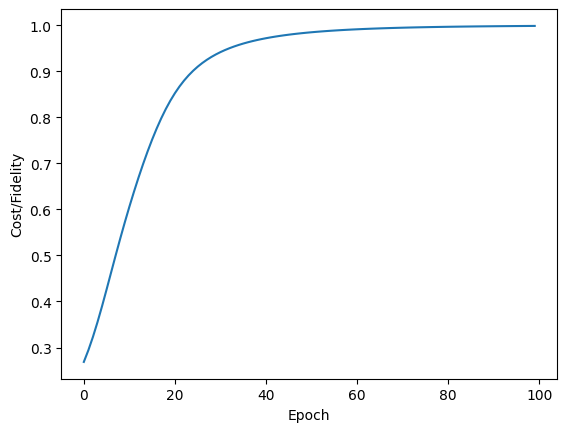

In [5]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Cost/Fidelity')